In [2]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
from cobaya import run

#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

In [3]:

para = [0.0228,0.1208,67.29,0.0542,0.945,2.0969]

In [11]:
#1 Dimension Brute Force
rangee = np.arange(0,0.1,0.00001)
chi_set =[]
for i in rangee:
    chi1 = 10-np.log(Cosmo_Power(para[0],para[1],para[2],i,para[4],para[5]))
    chi_set.append([i,chi1])

In [12]:
x = []
y = []
a = []
b = []
c= 1
r = []
rm = [0]
for i in chi_set:
    e = i[0]
    f = i[1]
    a.append(e)
    x.append(e)
    y.append(f)
    if f < c:
        b.append(0)
    else:
        b.append(f)
        r.append([e,f])
        if rm[0]<f:
            rm[0]=f
        else:
            None
P_Max = a[np.where(b == rm[0])[0][0]]
P_UP_Err = r[-1][0] - P_Max 
P_BT_Err = P_Max - r[0][0]

0.049980000000000004
0.050010000000000006


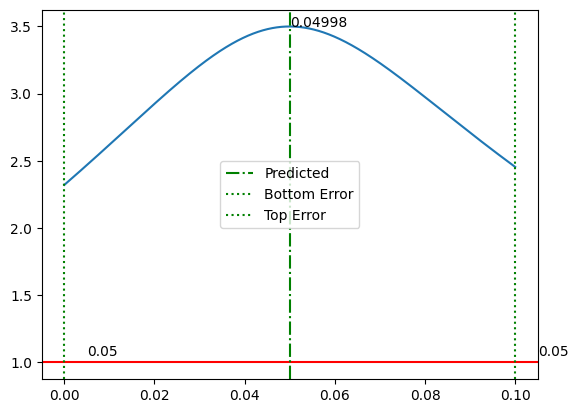

In [16]:
plt.plot(x,y)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=P_Max, color='green',linestyle='-.', label="Predicted")
plt.axvline(x=P_Max - P_BT_Err, color='green',linestyle='dotted', label="Bottom Error")
plt.axvline(x=P_Max + P_UP_Err, color='green',linestyle='dotted', label="Top Error")
plt.annotate(np.round(P_Max,8), xy=(P_Max, rm[0]), xytext=(P_Max,rm[0]))
plt.annotate(np.round(P_BT_Err,4), xy=(P_Max - P_BT_Err, 1), xytext=(P_Max - P_BT_Err +0.005, 1.05),)
plt.annotate(np.round(P_UP_Err,4), xy=(P_Max + P_UP_Err, 1), xytext=(P_Max + P_UP_Err +0.005, 1.05),)
plt.legend()
print(P_Max)
print(P_UP_Err)

In [18]:
#EMCEE
def emcee1(a,o):
    s = 10 - np.log(Cosmo_Power(o[0],o[1],o[2],a[0],o[3],o[4]))
    
    return (s)

In [19]:
ndim = 1 #Number Of Dimension
nwalkers = 50 #Number of Walkers

import emcee #import Emcee
erty = [0.0228,0.1224,67.85,0.968,2.0196]
sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee1, args=[erty])

p_initial = []
for l in np.arange(nwalkers):
    s = np.random.uniform(0,0.9)
    p_initial.append([s])


In [20]:
state = sampler.run_mcmc(p_initial,100,progress = True)
sampler.reset()

  5%|████                                                                              | 5/100 [00:01<00:31,  3.02it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_33712\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]


In [21]:
sampler.run_mcmc(state, 1000,progress = True);

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_33712\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
 22%|█████████████████▌                                                             | 223/1000 [01:06<03:30,  3.69it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_33712\1817034102.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
 26%|████████████████████▋                                                          | 262/1000 [01:18<04:10,  2.94it/s]D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)
100%|██████████████████████████████████████████████████████████████████████████████| 1000

In [22]:
flat_samples = sampler.get_chain(discard=100, flat=True)

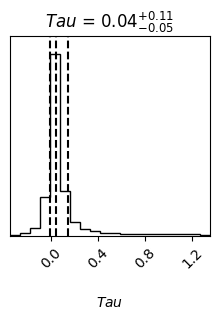

In [23]:
import corner

fig = corner.corner(
    flat_samples,
    labels=[
        r"$Tau$",
    ],
    quantiles=[0.16,0.5,0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

In [25]:
from IPython.display import display, Math
labels = ["tau"]
for i in np.arange(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16,50,84])
    #print(np.quantile(flat_samples[:, i],[0.16,0.5,0.84]))
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

In [441]:
print(np.shape(np.mean(flat_samples,axis=1)))

(45000,)


In [27]:
def cobaya_com(tau):
    return (10 - np.log(Cosmo_Power(0.0222,0.1204,68,tau,0.964,2.01)))

In [28]:
#COBAYA
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com}}
info["params"] = {
    "tau": {"prior": {"min": 0.001, "max": 0.9}, "proposal": 0.00001},
}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}
updated_info, sampler = run(info)

[cosmo1] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: tau:0.7915345
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {cosmo1: 148.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-04 21:03:12 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 8.810780 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 0.583351 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 8.854624 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 3.219104 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 200 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 1.415004 after 160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 0.802911 after 192 a

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* outlier fraction 0.007070707070707071 
(3960,)


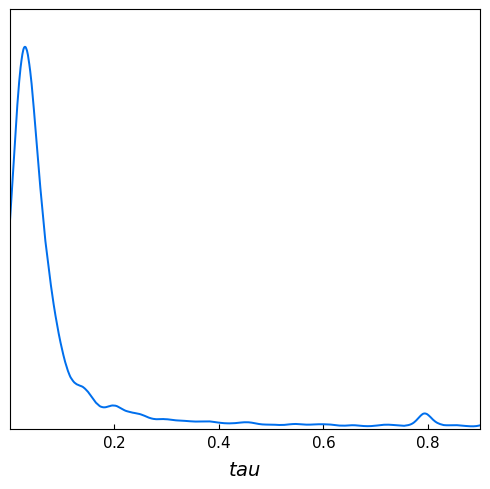

In [29]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["tau"], filled=True)
print(np.shape(gdsamples[2]))

In [30]:
p = ["omb","omc","h","tau","ns","AS"]
s = gdsamples.samples[np.argmin(gdsamples.loglikes)]
for i in np.arange(1):
    print("For the parameter ",p[i]," The acquired value is",s[i])

x = []
y = []

for i in np.arange(np.shape(gdsamples[0])[0]):
    x.append(gdsamples[0][i])
    y.append(gdsamples[1][i])


x1 = np.sort(x)
x2 = []
for i in x1:
    x2.append(i)
y1 = []
yc = []
ymax = 0 
for i in x2:
    rpos  = x.index(i)
    y4 = -y[rpos]
    y1.append(y4)
    if y4 < 1:
        None
    else:
        yc.append([i,y4])
        if ymax < y4:
            ymax = y4
        else:
            None
Ps_Max = x2[np.where(y1 == ymax)[0][0]]
Ps_UP = yc[-1][0] - Ps_Max 
Ps_BT = Ps_Max - yc[0][0] 
print(Ps_UP)

For the parameter  omb  The acquired value is 0.031123538032594742
0.18296742437304572


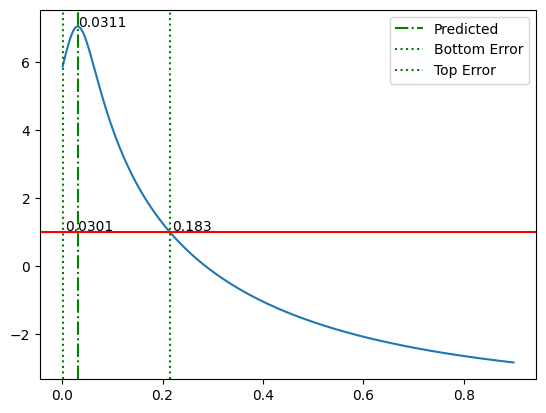

In [31]:
plt.plot(x2,y1)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=Ps_Max, color='green',linestyle='-.', label="Predicted")
plt.axvline(x=Ps_Max - Ps_BT, color='green',linestyle='dotted', label="Bottom Error")
plt.axvline(x=Ps_Max + Ps_UP, color='green',linestyle='dotted', label="Top Error")
plt.annotate(np.round(Ps_Max,4), xy=(Ps_Max, rm[0]), xytext=(Ps_Max,ymax))
plt.annotate(np.round(Ps_BT,4), xy=(Ps_Max - Ps_BT, 1), xytext=(Ps_Max - Ps_BT +0.005, 1.05),)
plt.annotate(np.round(Ps_UP,4), xy=(Ps_Max + Ps_UP, 1), xytext=(Ps_Max + Ps_UP +0.005, 1.05),)
plt.legend()